In [ ]:
%matplotlib inline
%load_ext watermark
%watermark -a 'Arttu Modig' -v -m -d -t -p numpy,pandas,seaborn,matplotlib,pystan,notebook

Arttu Modig 2017-08-24 12:49:35 

CPython 3.6.2
IPython 6.1.0

numpy 1.13.1
pandas 0.20.3
seaborn 0.8.0
matplotlib 2.0.2
pystan 2.16.0.1dev
notebook 5.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan
import seaborn as sns

os.environ["CC"] = "gcc"
os.environ["CXX"] = "g++"
os.environ["CXXFLAGS"] = "-O3 -mtune=native -march=native -Wno-unused-variable -Wno-unused-function"

In [ ]:
def plot_AB_test_mean_posteriors(ctrl_mean, test_mean, ctrl_conversion, test_conversion,
                                 N, iter_total, title="Posterior samples of log-normal revenue mean",
                                 xlabel="revenue mean"):
    """Plot A/B test mean posteriors"""
    fig, ax = plt.subplots()
    ax.hist(test_mean, bins=100, alpha=0.85, label="test")
    ax.hist(ctrl_mean, bins=100, alpha=0.65, label="ctrl")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.legend()
    # fine-tune
    y_max_orig = ax.get_ylim()[1]
    ax.set_ylim([0, 1.25 * y_max_orig])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.yaxis.set_visible(False)
    # info text
    ax.text(0, 0.99, 'Test group conversion: {k1:0.1f} %\nControl group conversion: {k0:0.1f} %\n'
            'Test sample size: {N}\nMCMC iterations: {iter}'\
            .format(k1=100*test_conversion, k0=100*ctrl_conversion, N=N, iter=iterations_total),
            fontsize=11, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    # mean lines
    ax.axvline(x=test_mean.mean(), ymax=1/1.3, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(x=ctrl_mean.mean(), ymax=1/1.3, color='black', linestyle='dashed', linewidth=1)
    height = ax.get_ylim()[1] - ax.get_ylim()[0]
    width = ax.get_xlim()[1] - ax.get_xlim()[0]
    ax.text(test_mean.mean() + 0.02 * width, 0.1 * height, '{0:.2f}'.format(test_mean.mean()),
            color='black', fontsize=11)
    ax.text(ctrl_mean.mean() + 0.02 * width, 0.1 * height, '{0:.2f}'.format(ctrl_mean.mean()),
            color='black', fontsize=11)

In [ ]:
%env CC

'gcc'

In [ ]:
%pwd

'/Users/amodig/git/R/stan'

In [ ]:
data = pd.read_csv("data_sales_grouped.csv")

In [ ]:
data.head()

,group,revenue,count,label
0,control,0.0,38314,1
1,control,1.0,4596,1
2,control,1.1,118,1
3,control,1.2,245,1
4,control,1.3,155,1


### Legacy model for A/B testing

In [ ]:
!cat legacy_updated.stan

data {
  int<lower=0> N;
  vector[N] y;
  int<lower=0, upper=2> x[N];  // bernoulli outcome
  vector[N] count;
}
transformed data {
}
parameters {
  vector[2] mu;
  vector<lower=0, upper=10>[2] sigma;  // lognormal sigma
  vector<lower=0, upper=1>[2] theta;  // bernoulli prob
}
model {
  mu ~ normal(2, 10);

  for (n in 1:N) {
    if (y[n] > 0)
      target += count[n] * (bernoulli_lpmf(0 | theta[x[n]])
                        + lognormal_lpdf(y[n] | mu[x[n]], sigma[x[n]]));
    else
      target += count[n] * bernoulli_lpmf(1 | theta[x[n]]);
  }
}
generated quantities {
  real pctrl ;
  real test ;

  // mean of log-normal distribution
  pctrl = exp(mu[1] + 0.5 * sigma[1] * sigma[1]);
  test = exp(mu[2] + 0.5 * sigma[2] * sigma[2]);
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL legacy_29467b2cb2e4729c84d332a69caf73c9 NOW.
INFO:pystan:OS: darwin, Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.26


Compiling /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_4356245692533080549.pyx because it changed.
[1/1] Cythonizing /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_4356245692533080549.pyx
building 'stanfit4legacy_29467b2cb2e4729c84d332a69caf73c9_4356245692533080549' extension
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var/folders
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var/folders/86
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpje8ja_6t/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpj

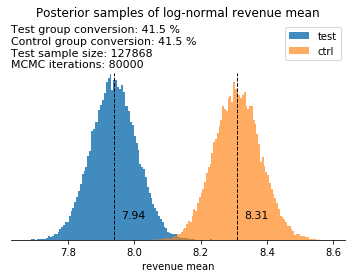

In [ ]:
iterations = 10000
chains = 8
iterations_total = iterations * chains

model_data = {"N": data.shape[0],
              "y": data['revenue'].astype(float).values,
              "x": data['label'].astype(int).values,
              "count": data['count'].astype(int).values}

# fit model
fit_legacy = pystan.stan(file="legacy_updated.stan", model_name="legacy",
                  data=model_data, iter=iterations, chains=chains,
                  n_jobs=-1, verbose=True)

# extract results
theta = fit_legacy.extract()['theta']  # theta is no-purchase rate in legacy model
conversion = 1 - theta
ctrl_conversion = np.mean(conversion[:,0])
test_conversion = np.mean(conversion[:,1])
ctrl_revenue = fit.extract()['pctrl'] #* conversion_0
test_revenue = fit.extract()['test'] #* conversion_1

# plot results
plot_AB_test_mean_posteriors(ctrl_mean=ctrl_revenue, test_mean=test_revenue,
                             ctrl_conversion = ctrl_conversion,
                             test_conversion = test_conversion,
                             N=data['count'].sum(), iter_total=iterations_total)

### New model for A/B/C/D/etc. testing

In [ ]:
!cat hier2.stan

functions {
  real lognormal_mean(real mu, real sigma) {
    return exp(mu + 0.5 * sigma * sigma);
  }
  real lognormal_sd(real mu, real sigma) {
    real a;
    real b;
    a = exp(sigma * sigma) - 1;
    b = exp(2 * mu + sigma * sigma);
    return sqrt(a * b); // sqrt of variance
  }
}
data {
  // notice we use grouped data per outcome value
  int<lower=0> N; // sum of unique outcomes
  int<lower=0> J; // number of test groups
  real<lower=0> y[N]; // observed outcome i.e. revenue
  int<lower=1> id[N]; // label for each unique outcome
  int<lower=1> count[N]; // count of each unique outcome
  real<lower=0> mean_log_y; // mean of log-positive outcomes
  real<lower=0> sd_log_y; // sd of log-positive outcomes
}
parameters {
  vector<lower=0, upper=1>[J] theta; // chance of success per test group, i.e. conversion rates per test group
  real<lower=0, upper=1> phi; // overall population chance of success
  real<lower=1> kappa; // population concentration
  vector<lower=0>[J] mu; // mu for 

In [ ]:
iterations = 50000
chains = 8
iterations_total = iterations * chains

rev = data['revenue']
rev = rev[rev > 0]
mean_log_y = np.mean(np.log(rev))
sd_log_y = np.std(np.log(rev))

model_data = {"N": data.shape[0],
            "J": data['label'].nunique(),
            "y": data['revenue'].astype(float).values,
            "id": data['label'].astype(int).values,  # id should start from 1!
            "count": data['count'].astype(int).values,
            "mean_log_y": mean_log_y,
            "sd_log_y": sd_log_y}

sm = pystan.StanModel(file="hier2.stan", verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c482f4f28a72c8c550d5171b82f50a44 NOW.
INFO:pystan:OS: darwin, Python: 3.6.2 |Anaconda custom (x86_64)| (default, Jul 20 2017, 13:14:59) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], Cython 0.26


Compiling /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/stanfit4anon_model_c482f4f28a72c8c550d5171b82f50a44_7104585506457188028.pyx because it changed.
[1/1] Cythonizing /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/stanfit4anon_model_c482f4f28a72c8c550d5171b82f50a44_7104585506457188028.pyx
building 'stanfit4anon_model_c482f4f28a72c8c550d5171b82f50a44_7104585506457188028' extension
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var/folders
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var/folders/86
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T
creating /var/folders/86/339xc0ws0nb5dtltnvzh88dw0000gn/T/tmpohwijs6b/var/folders/86/339xc0ws0nb5dtltnvzh88dw0

In [ ]:
fit_hier = sm.sampling(data=model_data, iter=iterations, chains=1, n_jobs=1, verbose=True,
                  control={'adapt_delta': 0.99, 'max_treedepth': 10})

In [ ]:
revenue_mean = fit_hier.extract()['revenue_mean'] 
revenue_std = fit_hier.extract()['revenue_std']
conversion = fit_hier.extract()['theta']

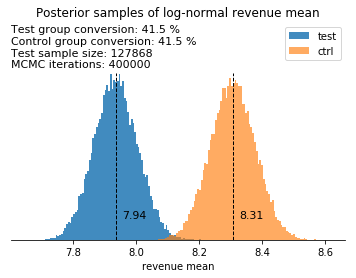

In [ ]:
plot_AB_test_mean_posteriors(ctrl_mean=revenue_mean[:,0], test_mean=revenue_mean[:,1],
                             ctrl_conversion = np.mean(conversion[:,0]),
                             test_conversion = np.mean(conversion[:,1]),
                             N=data['count'].sum(), iter_total=iterations_total)